In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
# Load results from previous fit.
#filename = 'ryan_iris_bnp_full_data_fit_alpha8.0.json'
#filename = 'ryan_simulation_bnp_full_data_fit_alpha1.0.json'
filename = 'ryan_simulation_bnp_full_data_fit_alpha1.0.json'
json_input_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [4]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [5]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 4.94273451e-01 -5.02554747e-01 -1.50129169e+00  1.44670941e+00
  -8.63777580e-02 -4.75925809e-02 -7.80983834e-03 -2.22837438e-03
  -7.58740505e-04 -2.76012007e-04 -1.05072586e-04 -1.05077633e-04]
 [ 5.36981139e-01 -5.21053456e-01 -1.51280086e+00  6.86874390e-01
   2.84497078e-01  4.77473956e-02  9.78624352e-03  3.08008383e-03
   1.08023919e-03  3.89189553e-04  1.39096276e-04  1.39077593e-04]]
	cluster_weights:
[4.16877319e-01 3.30770581e-01 2.48023382e-01 3.03104942e-03
 7.01473082e-04 3.05755038e-04 1.46524504e-04 7.21861626e-05
 3.59030775e-05 1.79185948e-05 8.95416388e-06 8.95416388e-06]
	v_sticks:
[-3.35946874e-01  2.71067689e-01  4.16089736e+00  1.02917122e+00
  2.28090290e-01  7.61896645e-02  2.72197023e-02  9.68699798e-03
  3.25483616e-03  8.79573586e-04  2.63788888e-10]


In [6]:
import functional_sensitivity_lib as fun_sens_lib
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)

In [7]:
print(model.prior_params)

prior_params:
	alpha: [1.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.  ]
 [0.   0.62]]


In [8]:
# Define a perturbation in the logit v space.

phi_center = 0.
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))

0.6931471805599453


In [82]:
import scipy as osp
val, err = osp.integrate.quadrature(phi, -4, 4)

class PriorPerturbation(object):
    def __init__(self, stick_sens, log_phi, log_epsilon=0.0):
        self.stick_sens = stick_sens
        self.logit_v_lb = -4
        self.logit_v_ub = 4
        self.set_phi(log_phi, log_epsilon)
        
    def get_log_p0(self, v):
        return \
            self.stick_sens.get_log_p0_stick(v) - \
            self.log_norm_p0

    def get_log_p0_logit(self, logit_v):
        return \
            self.stick_sens.get_log_p0_logit_stick(logit_v) - \
            self.log_norm_p0_logit

    def get_log_pc(self, v):
        logit_v = np.log(v) - np.log(1 - v)
        return \
            self.get_log_p0(v) + \
            self.log_phi(logit_v) + \
            self.log_epsilon - \
            self.log_norm_pc

    def get_log_pc_logit(self, logit_v):
        return \
            self.get_log_p0_logit(logit_v) + \
            self.log_phi(logit_v) + \
            self.log_epsilon - \
            self.log_norm_pc_logit

    def set_log_epsilon(self, log_epsilon):
        self.set_phi(self.log_phi, log_epsilon)
        
    def set_phi(self, log_phi, log_epsilon):
        # Set attributes derived from phi and epsilon
        
        # Initial values for the log normalzing constants which will be
        # set in set_phi.
        self.log_norm_p0 = 0
        self.log_norm_pc = 0
        self.log_norm_p0_logit = 0
        self.log_norm_pc_logit = 0

        self.log_phi = log_phi
        self.log_epsilon = log_epsilon
        
        norm_p0, _ = osp.integrate.quadrature(
            lambda v: np.exp(self.get_log_p0(v)), 0, 1)
        assert norm_p0 > 0 
        self.log_norm_p0 = np.log(norm_p0)

        norm_pc, _ = osp.integrate.quadrature(
            lambda v: np.exp(self.get_log_pc(v)),
            0, 1)
        assert norm_pc > 0 
        self.log_norm_pc = np.log(norm_pc)
        
        norm_p0_logit, _ = osp.integrate.quadrature(
            lambda logit_v: np.exp(self.get_log_p0_logit(logit_v)),
            self.logit_v_lb, self.logit_v_ub)
        assert norm_p0_logit > 0 
        self.log_norm_p0_logit = np.log(norm_p0_logit)

        norm_pc_logit, _ = osp.integrate.quadrature(
            lambda logit_v: np.exp(self.get_log_pc_logit(logit_v)),
            self.logit_v_lb, self.logit_v_ub)
        assert norm_pc_logit > 0 
        self.log_norm_pc_logit = np.log(norm_pc_logit)
        

prior_perturbation = PriorPerturbation(stick_sens, log_phi)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

0.0 -1.3510778981832263 -0.03663537377491137 -1.314446956474002


phi max:  0.49989900265152387


Text(0.5,1,'Priors in logit space')

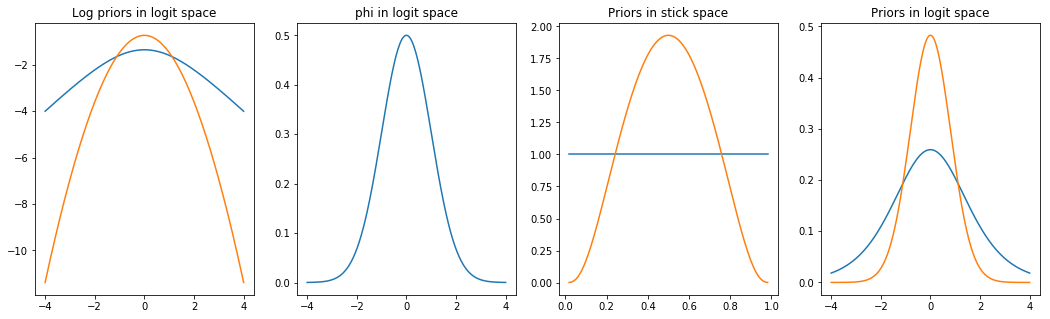

In [84]:
prior_perturbation.set_log_epsilon(np.log(100))

logit_v_grid = np.linspace(-4, 4, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [85]:
# Choose the number of GH points.
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

perturbed_log_density = lambda x : np.log(1.0 + phi(x))

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        gmm_utils.get_e_log_perturbation_vec(vb_params, phi))

expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1) 
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

33 33 96


In [86]:
# TODO: combine this with the other class
class PerturbedPrior(object):
    def __init__(self, model, phi, epsilon=0.0):
        self.phi = phi
        self.model = model
        self.epsilon_param = vb.ScalarParam('epsilon', lb=0.0)
        self.epsilon_param.set(epsilon)
        
    def epsilon_phi(self, x):
        return self.phi(x) * self.epsilon_param.get()
        
    def get_e_log_prior_for_kl(self):
        return -1 * np.sum(gmm_utils.get_e_log_perturbation_vec(
            self.model.vb_params, self.epsilon_phi))
        
perturbed_prior = PerturbedPrior(model, phi)
perturbed_prior.get_e_log_prior_for_kl()

-0.0

In [87]:
# First fit with no perturbation but the increased number of gh points.
model.phi = None
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

# best_param_0, vb_opt_0, opt_time_0, \
# kl_hessian_0, kl_hessian_corrected_0 = \
#     model.precondition_and_optimize(
#         best_param, kl_hessian=kl_hessian)

best_param_0, kl_hessian_0, kl_hessian_corrected, \
init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
    model.optimize_full(
        best_param,
        init_max_iter=100,
        final_max_iter=500)

print('Done. ')

BGFS
Iter: 0	 RMSE: 14.108646587387742	 Objective: -273.6488454239062
Iter: 10	 RMSE: 14.10861438010126	 Objective: -273.6488500661245
Iter: 20	 RMSE: 14.108644185293304	 Objective: -273.64885220505107
Iter: 30	 RMSE: 14.108691910235365	 Objective: -273.64885357388835
Iter: 40	 RMSE: 14.10867591787594	 Objective: -273.64885369661806
Iter: 50	 RMSE: 14.108688665726133	 Objective: -273.64885370186164
Optimization terminated successfully.
         Current function value: -273.648854
         Iterations: 43
         Function evaluations: 57
         Gradient evaluations: 57
Conditioned Newton:
i =  0
Optimization terminated successfully.
         Current function value: -273.648854
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 1: x_diff = 5.0614487816042796e-05, f_diff = 1.0231815394945443e-11
Done. 


In [88]:
epsilon_sensitivity = obj_lib.ParametricSensitivity(
    objective_fun=model.set_z_get_kl,
    input_par=model.global_vb_params,
    output_par=moment_model.moment_params,
    hyper_par=perturbed_prior.epsilon_param,
    input_to_output_converter=moment_model.set_moments,
    optimal_input_par=best_param_0,
    objective_hessian=kl_hessian_0,
    hyper_par_objective_fun=perturbed_prior.get_e_log_prior_for_kl)

## Fit with perturbation

In [74]:
# Then fit with the perturbation.
log_epsilon = np.log(10)
epsilon = np.exp(log_epsilon)

def phi_eps(x):
    return np.exp(np.log(phi(x)) + log_epsilon)

model.phi = phi_eps

# best_param_phi, vb_opt_phi, opt_time_phi, \
# kl_hessian_phi, kl_hessian_corrected_phi = \
#     model.precondition_and_optimize(
#         best_param_0, kl_hessian=kl_hessian_0)

best_param_phi, kl_hessian_phi, kl_hessian_corrected_phi, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
    model.optimize_full(
        best_param_0,
        init_max_iter=100,
        final_max_iter=500)

print('Done. ')

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

BGFS
Iter: 0	 RMSE: 14.108686178541399	 Objective: -286.0569663451207
Iter: 10	 RMSE: 14.118893312317677	 Objective: -286.90873903453235
Iter: 20	 RMSE: 14.127311637077414	 Objective: -287.3118033190964
Iter: 30	 RMSE: 14.087081013739258	 Objective: -287.62728588460794
Iter: 40	 RMSE: 14.057474812039853	 Objective: -287.7109590078303
Iter: 50	 RMSE: 14.059265608625834	 Objective: -287.7136340329086
Iter: 60	 RMSE: 14.057840038109306	 Objective: -287.7142002599557
Iter: 70	 RMSE: 14.058096924970013	 Objective: -287.7142305594293
Iter: 80	 RMSE: 14.05809195364865	 Objective: -287.71423082323406
Optimization terminated successfully.
         Current function value: -287.714231
         Iterations: 72
         Function evaluations: 90
         Gradient evaluations: 90
Conditioned Newton:
i =  0
Iter: 90	 RMSE: 14.058092986974213	 Objective: -287.7142308246548
Optimization terminated successfully.
         Current function value: -287.714231
         Iterations: 1
         Function evaluati

In [89]:
best_param_phi_pred = epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(epsilon, linear=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Predicted differences:  9.865927966964353


Epsilon: 10.000000000000002


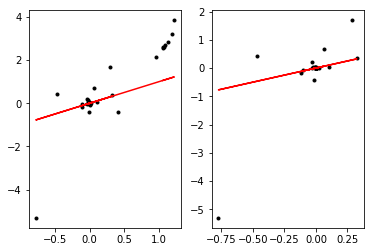

In [90]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
plt.plot(output_phi - output_0, output_phi - output_0, 'r')

## Influence function stuff

In [ ]:
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)

In [ ]:
influence_vals = np.array([
    stick_sens.get_all_stick_influence(logit_v) for logit_v in logit_v_grid ])

In [ ]:
def get_log_q_grad_vec(self, logit_v):
    log_q_grad_vec = np.array([
        self.log_q_logit_stick_obj.fun_free_grad(
            self.best_param, logit_v=logit_v, k=k)
        for k in range(self.model.k_approx - 1) ])
    return log_q_grad_vec
log_q_grads = np.array([ get_log_q_grad_vec(stick_sens, logit_v) for logit_v in logit_v_grid ])

In [ ]:
log_p0 = stick_sens.get_log_p0_logit_stick(logit_v_grid)
log_q_vec = np.array([
    stick_sens.get_log_q_logit_all_sticks(logit_v) \
    for logit_v in logit_v_grid ])

print(log_q_grads.shape)
print(log_p0.shape)
print(log_q_vec.shape)


In [ ]:
def get_all_stick_influence_times_phi(self, logit_v_grid, log_q_grads, log_phi, log_epsilon=0):
    # The prior is the same for every stick.
    log_p0 = stick_sens.get_log_p0_logit_stick(logit_v_grid)[:, np.newaxis]
    log_perturbation = log_phi(logit_v_grid)[:, np.newaxis] + log_epsilon
    log_q_vec = np.array([
        stick_sens.get_log_q_logit_all_sticks(logit_v) \
        for logit_v in logit_v_grid ])

    #print(log_q_vec.shape)
    #print(log_p0.shape)
    #print(log_perturbation.shape)
    
    #dens_ratios = np.exp(log_q_vec - log_p0 + log_perturbation)
    dens_ratios = np.exp(log_q_vec + log_perturbation)
    #print(self.lr_mat.shape)
    #print(log_q_grads.shape)
    #print(dens_ratios.shape)
    
    # d indexes the free parameters
    # g indexes the moments of interest
    # n indexes the grid points in logit_v_grid
    # k indexes the stick
    return(np.einsum('dg,nkd,nk->ng', self.lr_mat, log_q_grads, dens_ratios))

influence_phi_vals = \
    get_all_stick_influence_times_phi(
        stick_sens, logit_v_grid, log_q_grads, log_phi, log_epsilon=log_epsilon)

In [ ]:
#plt.plot(logit_v_grid, influence_phi_vals[:, 0]);
plt.plot(logit_v_grid[1:], (np.diff(logit_v_grid)[:, np.newaxis] * influence_phi_vals[1:,0]).T);

In [ ]:
def get_moments(free_par, moment_model):
    moment_model_copy = deepcopy(moment_model)
    moment_model_copy.set_moments_from_free_par(free_par)
    return moment_model.moment_params.get_vector()

pred_influence = np.sum(
    np.diff(logit_v_grid)[:, np.newaxis] * influence_phi_vals[1:,:], axis=0)
print(pred_influence.shape)

true_moment_diff = get_moments(best_param_phi, moment_model) - get_moments(best_param_0, moment_model)

In [ ]:
plt.plot(pred_influence, true_moment_diff, 'k.')
plt.plot(true_moment_diff, true_moment_diff, 'r')